In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('precision', 3)

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

Libraries Loaded!


# Getting the Data

The data has already been split into a training set ('train.csv') and a test set ('test.csv'). We can use the `read_csv()` method to load them as Pandas dataframes:

In [2]:
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

print ('Dataframes loaded!')
print ('Training set: {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print ('    Test set: {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

Dataframes loaded!
Training set: 891 rows and 12 columns
    Test set: 418 rows and 11 columns


In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


The meaning of each attribute is the following:

- **PassengerId**: the ID given to each passenger,
- **Survived**: the target attribute (1 for passengers who survived, 0 for those who didn't),
- **Pclass**: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd class),
- **Name**, **Sex**, **Age**: self-explanatory,
- **SibSp**: Number of siblings & spouses aboard the Titanic,
- **Parch**: Number of parents & children aboard the Titanic,
- **Ticket**: Ticket number, 
- **Fare**: Passenger fare (in pounds),
- **Cabin**: Passenger's cabin number, and
- **Embarked**: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

'PassengerId' is unique to each passenger and can be dropped:

PassengerId값은 승객들마다 있는 고유값이므로 데이터분석에는 사용하지 않음

In [4]:
train_df.drop('PassengerId', axis = 1, inplace = True)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


각 feature 별로 비어있는 데이터들의 개수 및 비율 출력

In [6]:
missing_counts = train_df.isnull().sum()
percent = (missing_counts*100/train_df.shape[0])

missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
display(missing_df.style.background_gradient())

,Counts,%
Survived,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000
Age,177,19.865
SibSp,0,0.000
Parch,0,0.000
Ticket,0,0.000
Fare,0,0.000
Cabin,687,77.104


Age의 빈칸은 중간값으로 채우고, Cabin은 빈값이 너무 많으므로 사용할 수 없음

In [7]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,714.000,891.000,891.000,891.000
mean,0.384,2.309,29.699,0.523,0.382,32.204
std,0.487,0.836,14.526,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,20.125,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,38.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


데이터 형태가 숫자인 feature 들을 시각화해보기

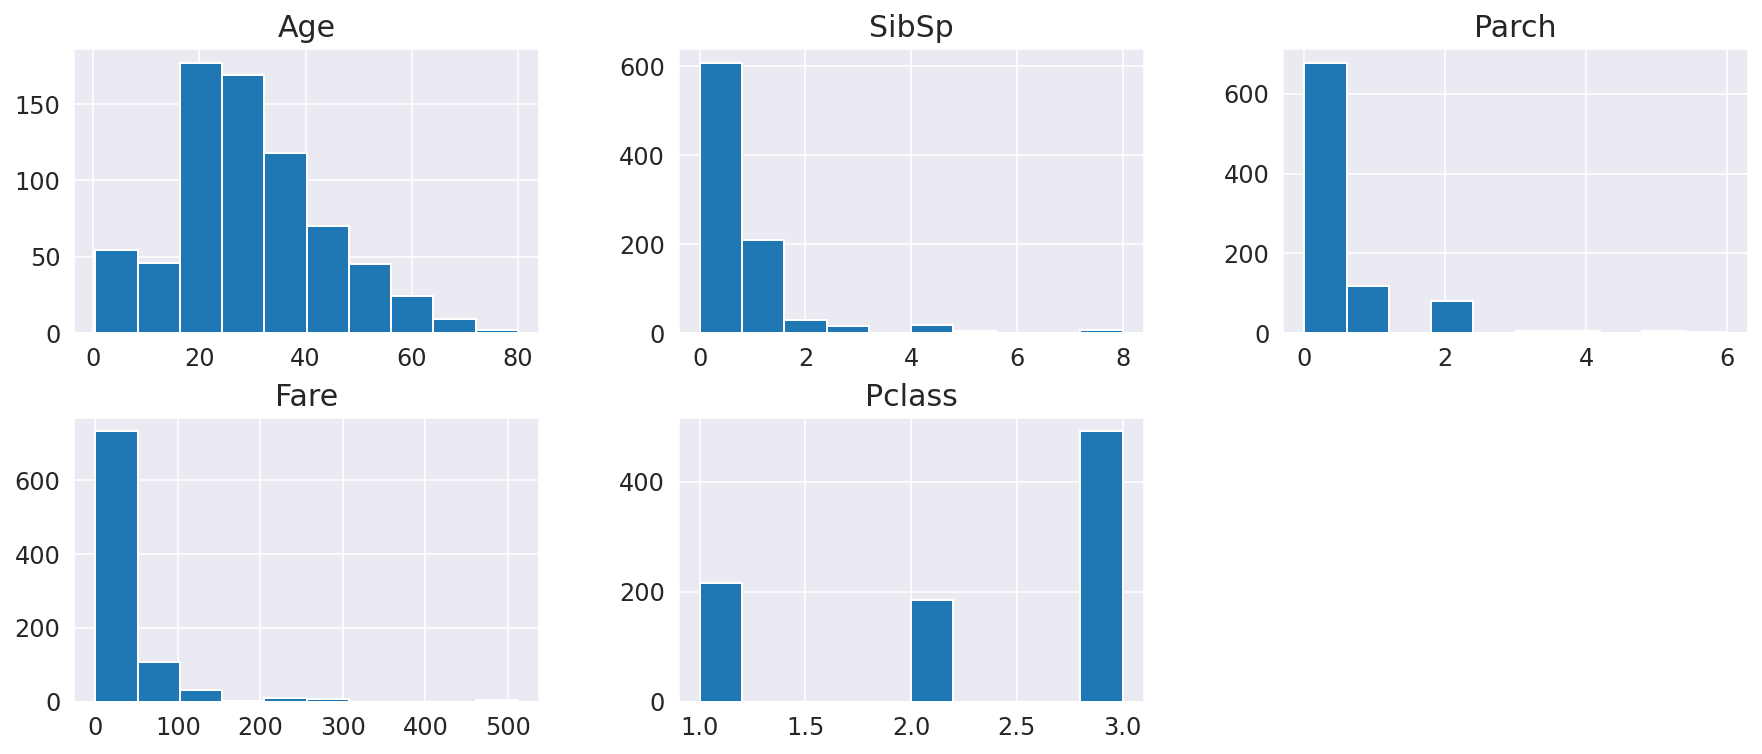

In [8]:
num_atts = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
train_df[num_atts].hist(figsize = (15, 6), layout = (2, 3));

그래프를 통해 승객들의 나이가 대체적으로 어렸고, SibSp와 Parch를 통해 친인척이 없는 사람들이 대부분이었으며, 대체적으로 낮은 요금을 내고 탄 사람들과 class 3 의 승객들이 가장 많았음을 확인가능

각 요소별 세부분석

1. 성별에 따른 생존율

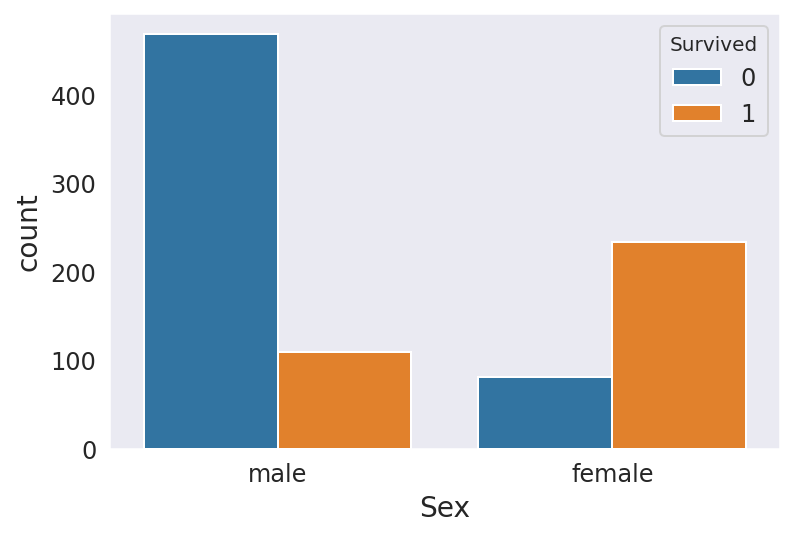

In [9]:
sns.countplot(x = 'Sex', hue = 'Survived', data = train_df);

남자의 생존율은 아주 낮고, 여자의 생존율은 상대적으로 높은것을 알 수 있음

2. 나이 : 20살을 간격으로 해서 연령별 생존률 확인

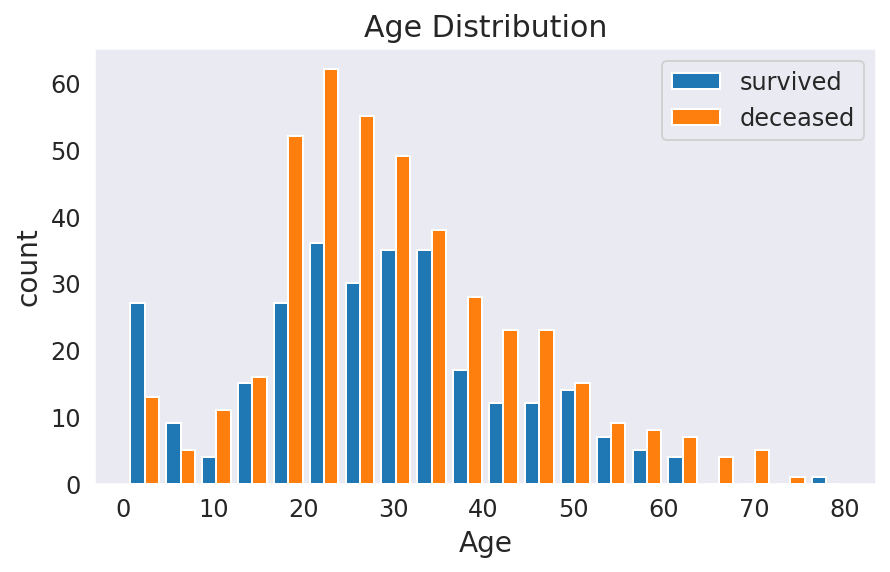

In [10]:
plt.figure(figsize = (7, 4))
people_survived = train_df[train_df['Survived'] == 1]['Age'].dropna()
people_deceased = train_df[train_df['Survived'] == 0]['Age'].dropna()

plt.hist((people_survived, people_deceased), label=["survived", "deceased"], bins=20)
plt.legend()
plt.xlabel("Age")
plt.ylabel("count")
plt.title("Age Distribution");

15~40세 사이 구간에서의 생존률이 올라가는것 확인, 0세에 가까운 유아들의 생존률은 확실히 높음

따라서 나이구간의 bin을 15간격으로 데이터 가공

In [11]:
train_df['Age_Bin'] = (train_df['Age']//15)*15
train_df[['Age_Bin', 'Survived']].groupby(['Age_Bin']).mean()

,Survived
Age_Bin,
0.0,0.577
15.0,0.363
30.0,0.423
45.0,0.404
60.0,0.240
75.0,1.000


3. 탑승 항구

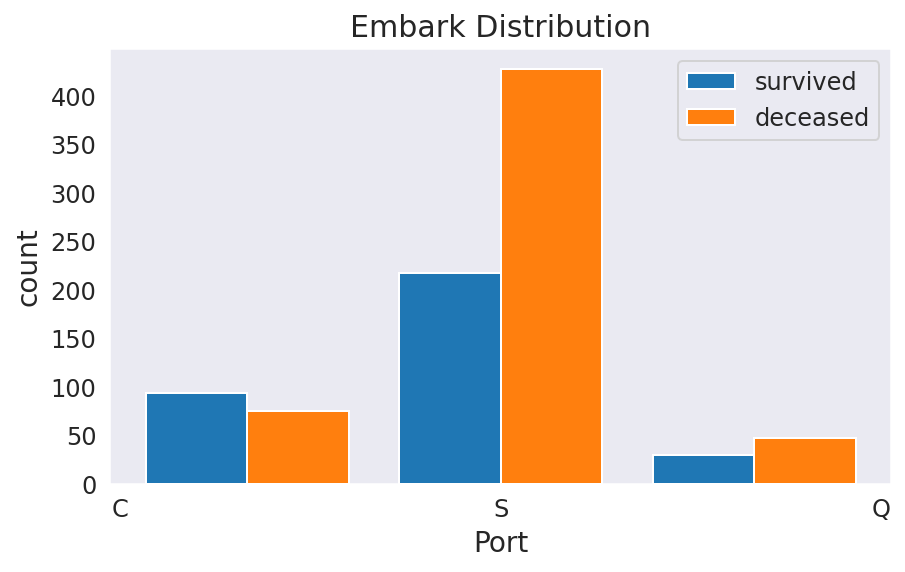

In [12]:
plt.figure(figsize = (7, 4))
people_survived = train_df[train_df['Survived'] == 1]['Embarked'].dropna()
people_deceased = train_df[train_df['Survived'] == 0]['Embarked'].dropna()

plt.hist((people_survived, people_deceased), label=["survived", "deceased"], bins = 3)
plt.legend()
plt.xlabel("Port")
plt.ylabel("count")
plt.title("Embark Distribution");

Embarked는 승선한 항구를 말하는데, Southampton의 사망률이 다른곳보다 상대적으로 높긴 하지만, 배가 한 지점에서 침몰했으므로 탑승항구와의 연관성을 따져야하는지 잘 모르겠으므로 보류

4. 좌석 클래스

In [13]:
# 각 클래스별 승객 수
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

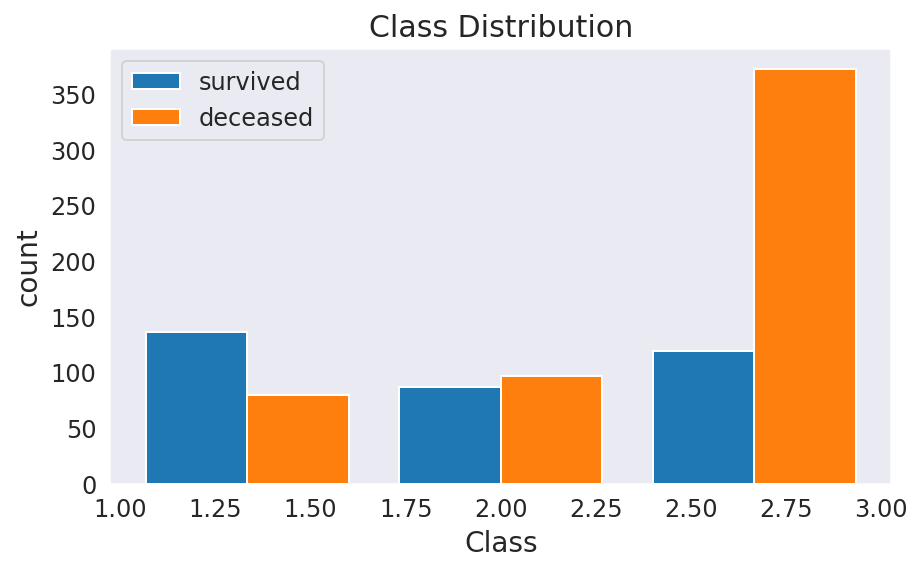

In [14]:
plt.figure(figsize = (7, 4))
people_survived = train_df[train_df['Survived'] == 1]['Pclass']
people_deceased = train_df[train_df['Survived'] == 0]['Pclass']

plt.hist((people_survived, people_deceased), label=["survived", "deceased"], bins = 3)
plt.legend()
plt.xlabel("Class")
plt.ylabel("count")
plt.title("Class Distribution");

3등석 승객들의 사망률이 1,2등석에 비해 월등히 높음을 확인할 수 있음

5. 요금

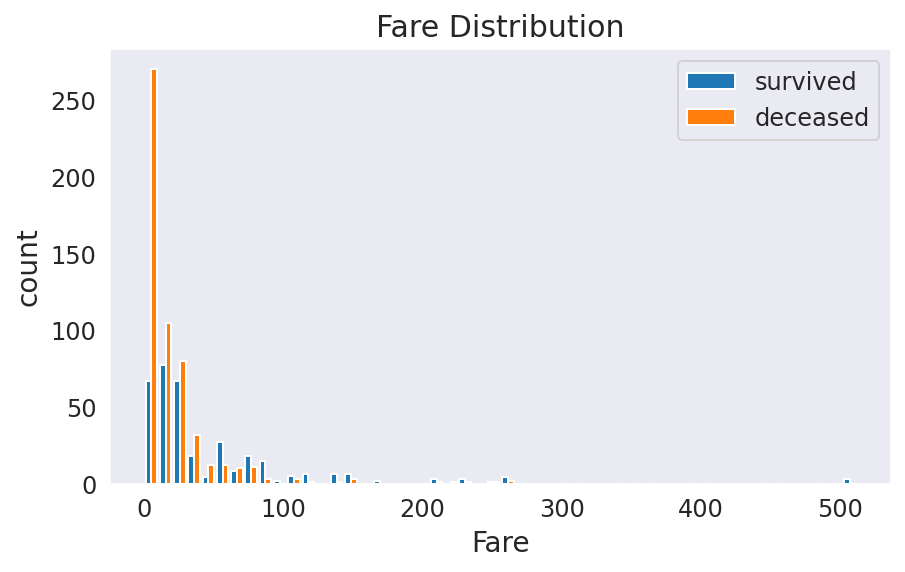

In [15]:
plt.figure(figsize = (7, 4))
people_survived = train_df[train_df['Survived'] == 1]['Fare']
people_deceased = train_df[train_df['Survived'] == 0]['Fare']

plt.hist((people_survived, people_deceased), label=["survived", "deceased"], bins =50)
plt.legend()
plt.xlabel("Fare")
plt.ylabel("count")
plt.title("Fare Distribution");

클래스 비교와 비슷한 결과로, 저렴한 요금을 낸 승객들의 사망률은 높고, 비싼요금을 낸 승객들의 생존율이 높음

요금을 50단위로 범주화

In [16]:
train_df['Fare_Bin'] = (train_df['Fare']//50)*50
train_df[['Fare_Bin', 'Survived']].groupby(['Fare_Bin']).mean()

,Survived
Fare_Bin,
0.0,0.319
50.0,0.648
100.0,0.792
150.0,0.667
200.0,0.636
250.0,0.667
500.0,1.000


In [17]:
train_df['Fare_Bin'] = pd.qcut(train_df['Fare'], 5)
train_df[['Fare_Bin', 'Survived']].groupby(['Fare_Bin']).mean()

,Survived
Fare_Bin,
"(-0.001, 7.854]",0.218
"(7.854, 10.5]",0.201
"(10.5, 21.679]",0.424
"(21.679, 39.688]",0.444
"(39.688, 512.329]",0.642



6. SibSp, Parch : 배에 부모, 형제, 배우자, 자녀가 몇명 탑승해있는지

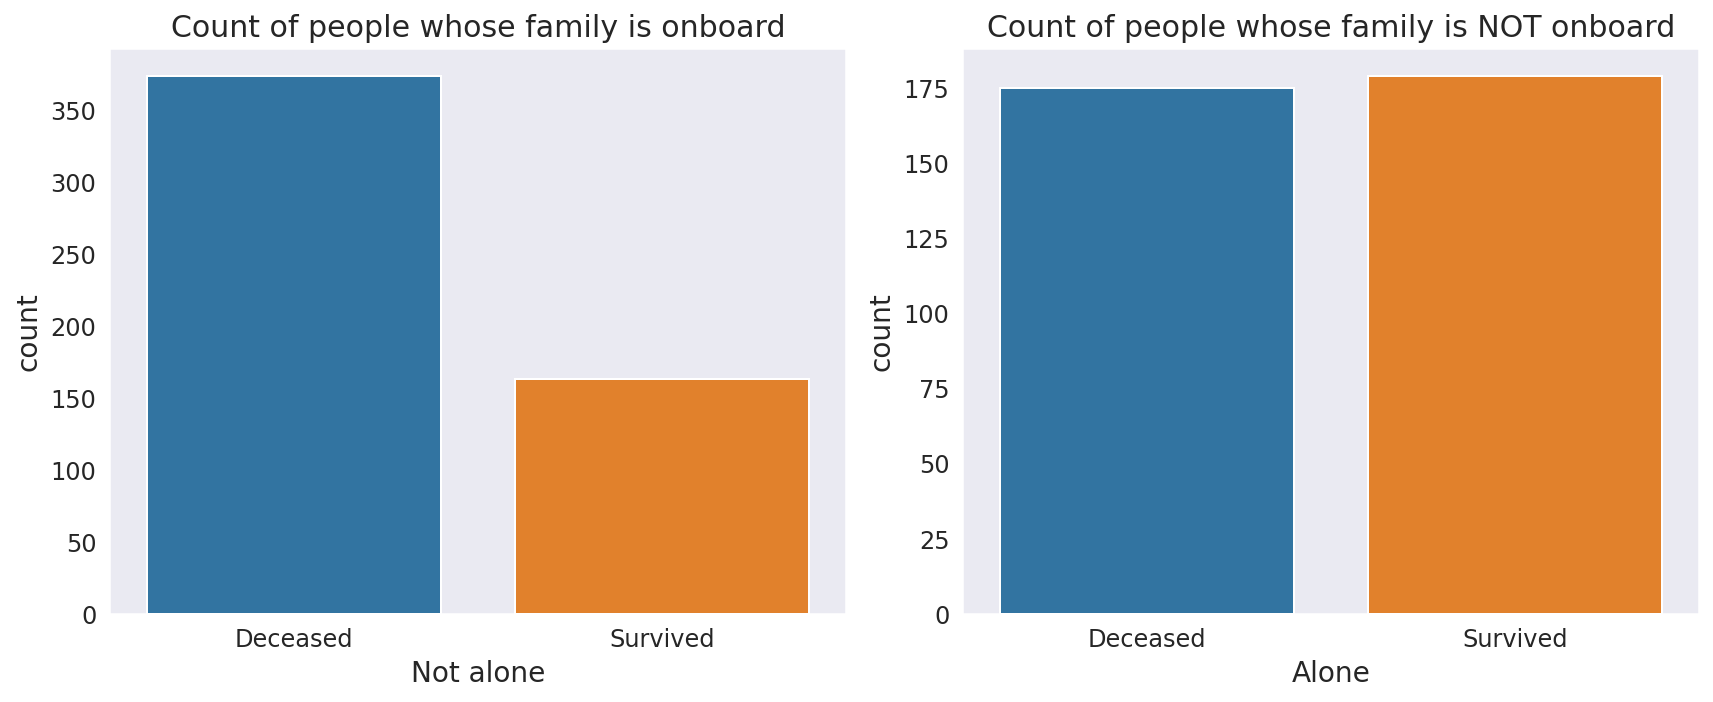

In [18]:
alone = train_df[(train_df['SibSp'] == 0) & (train_df['Parch'] == 0)]
not_alone = train_df[(train_df['SibSp'] != 0) | (train_df['Parch'] != 0)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.countplot(x = 'Survived', data = alone, ax = ax1) 
ax1.set_title('Count of people whose family is onboard')
ax1.set_xlabel('Not alone')
ax1.set_xticklabels(['Deceased', 'Survived'])
ax1.set_ylabel('count')

sns.countplot(x = 'Survived', data = not_alone, ax = ax2) 
ax2.set_title('Count of people whose family is NOT onboard')
ax2.set_xlabel('Alone')
ax2.set_xticklabels(['Deceased', 'Survived'])
ax2.set_ylabel('count')

plt.tight_layout();

배에 가족이 있었던 경우 생존률이 없는그룹에 비해 높은것을 확인할 수 있음


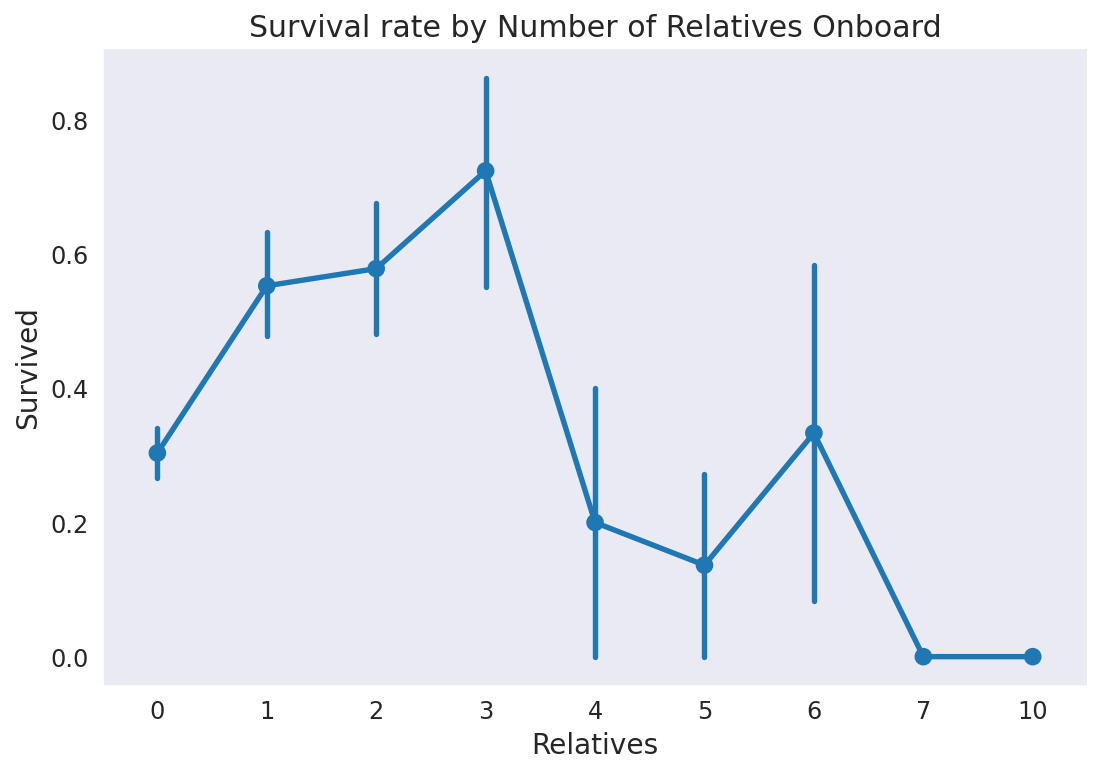

In [19]:
train_df['Relatives'] = train_df['SibSp'] + train_df['Parch']

sns.factorplot('Relatives', 'Survived', data = train_df, aspect = 1.5)
plt.title('Survival rate by Number of Relatives Onboard');

특히 가족이 1명~3명이었던 경우 생존률이 높았음

요약


|      Attribute      |    Use    |            Bin              |
|:-------------------:|:---------:|:---------------------------:|
|     PassengerId     |     No    |              -              |
|         Sex         |    Yes    |              -              |
|         Age         |    Yes    |        Bin                  |
| Port of Embarkation |     No    |              -              |
|        Pclass       |    Yes    |              -              |
|         Fare        |    Yes    |        Bin                  |
|   SibSp and Parch   |    Yes    |     change into 'Relatives' |
|         Name        |     No    |              -              |
|        Cabin        |     No    |              -              |
|        Ticket       |     No    |              -              |

한번에 데이터를 가공하기 위해 train 데이터와 test 데이터를 합침

In [20]:
all_data = pd.concat([train_df, test_df])

In [21]:
#비어있는값 중간값으로 채우기
all_data['Age'] = all_data['Age'].fillna(train_df['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(train_df['Fare'].median())

#범주화
all_data['Age_Bin'] = (all_data['Age']//15)*15
all_data['Fare_Bin'] = pd.qcut(all_data['Fare'], 5)
all_data['Relatives'] = all_data['SibSp'] + all_data['Parch']

데이터 인코딩하기

In [22]:
all_data['Fare_Bin'] = LabelEncoder().fit_transform(all_data['Fare_Bin'])
all_data['Age_Bin'] = LabelEncoder().fit_transform(all_data['Age_Bin'])
all_data['Sex'] = LabelEncoder().fit_transform(all_data['Sex'])

가공완료 후에 다시 train data 와 test data로 분리하기

In [23]:
features = ["Pclass", "Fare_Bin", "Age_Bin", "Relatives", "Sex"]

X_train = all_data[features][:891]
y_train = all_data['Survived'][:891]

#######################################################

X_test = all_data[features][891:]

print(X_train.head())
print(X_test.head())
print(y_train.head())

   Pclass  Fare_Bin  Age_Bin  Relatives  Sex
0       3         0        1          1    1
1       1         4        2          1    0
2       3         1        1          0    0
3       1         4        2          1    0
4       3         1        2          0    1
   Pclass  Fare_Bin  Age_Bin  Relatives  Sex
0       3         0        2          0    1
1       3         0        3          1    0
2       2         1        4          0    1
3       3         1        1          0    1
4       3         2        1          2    0
0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64


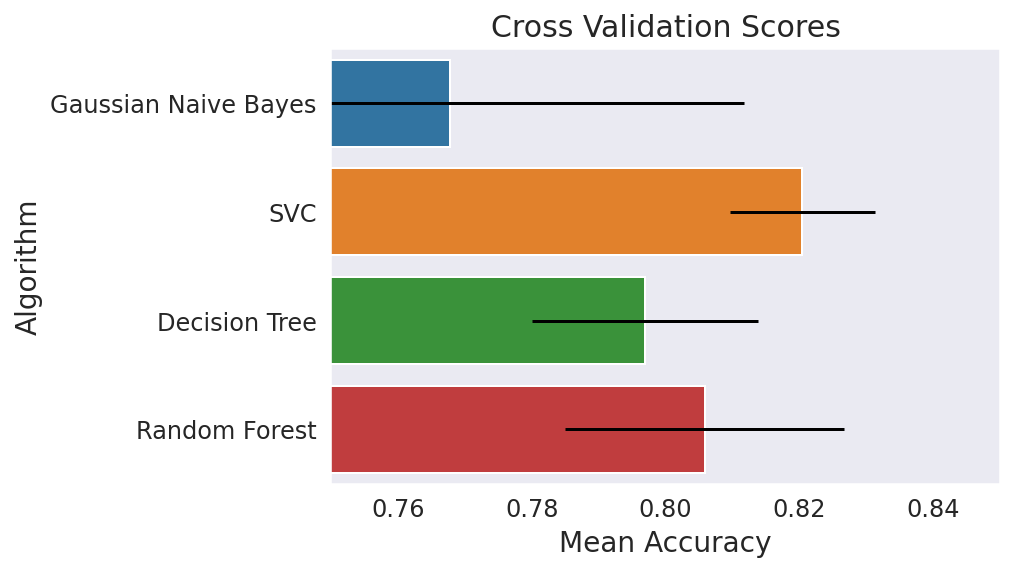

In [24]:
random_state = 1

# 모델들 생성
clf_list = [GaussianNB(), 
            SVC(random_state = random_state, probability = True),
            DecisionTreeClassifier(random_state = random_state), 
            RandomForestClassifier(random_state = random_state)]


# 각 머신러닝의 cv mean 을 측정
cv_base_mean, cv_std = [], []
for clf in clf_list:  
    cv = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = 5, n_jobs = -1)
    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

    
# 결과를 그래프로 시각화
cv_total = pd.DataFrame({'Algorithm': ['Gaussian Naive Bayes', 'SVC', 'Decision Tree', 'Random Forest'],
                         'CV-Means': cv_base_mean, 
                         'CV-Errors': cv_std})

sns.barplot('CV-Means', 'Algorithm', data = cv_total, orient = 'h', **{'xerr': cv_std})
plt.xlabel('Mean Accuracy')
plt.title('Cross Validation Scores')
plt.xlim([0.75, 0.85]);

## Submission

In [25]:
my_clf = SVC(random_state = random_state, probability = True)

my_clf.fit(X_train, y_train)
prediction = my_clf.predict(X_test)

pd.DataFrame(data = {'PassengerId': test_df.PassengerId, 
                     'Survived':prediction.astype(int)}).to_csv('submission.csv', index = False)